COMP5930M Scientific Computation - Tutorial 8  \\
Direct linear solvers

To illustrate the performance of direct solution algorithms for large linear systems, we experiment with three different linear problems from Matrix Market (https://math.nist.gov/MatrixMarket/). If using Google Colab, you need to upload the three .mtx files to your local session storage.

Matrix 1: Structural engineering problem of a frame within a suspension bridge

Matrix 2: 3D model of an oil reservoir

Matrix 3: Lid-driven cavity flow in a box

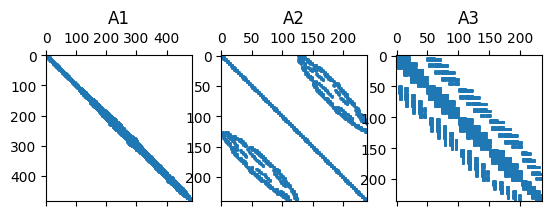

In [84]:
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
import numpy as np
import time

A1 = mmread('bcsstk20.mtx')
A2 = mmread('steam1.mtx')
A3 = mmread('e05r0100.mtx')

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A1, markersize=1)
ax1.set_title('A1')
ax2.spy(A2, markersize=1)
ax2.set_title('A2')
ax3.spy(A3, markersize=1)
ax3.set_title('A3')

plt.show()

By plotting the sparsity patterns of the three matrices, we can observe they are all sparse but have very different sparsity patterns. $A_1$ is mostly diagonal, whereas $A_2$ has many elements away from the diagonal due to the 3D discretisation, and $A_3$ has many more nonzero elements in a block pattern (typical for higher-order spatial discretisation methods). This will have implications to the efficiency of matrix factorisations.

We will make use of the scipy.sparse.linalg.splu method for sparse LU-factorisation (provided by the SuperLU library, https://portal.nersc.gov/project/sparse/superlu/).

First let's look at how the LU-factors of the problem $A_1$ look like:

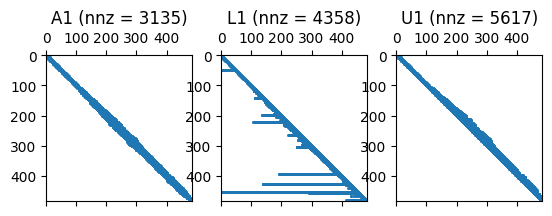

In [85]:


LU1 = sp.linalg.splu(A1, 'NATURAL') # Compute A = LU without any reordering

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A1, markersize=1)
ax1.set_title('A1 (nnz = ' + str(A1.getnnz()) + ')')
ax2.spy(LU1.L, markersize=1)
ax2.set_title('L1 (nnz = ' + str(LU1.L.getnnz()) + ')')
ax3.spy(LU1.U, markersize=1)
ax3.set_title('U1 (nnz = ' + str(LU1.U.getnnz()) + ')')

plt.show()

From the sparsity patterns of $U$ and $L$ we can observe that the factors remain generally sparse, but the number of nonzeros increases slightly. To evaluate the efficiency, we solve the linear problem $A_1 x = b$ 1000 time using the LU-factorisation without reordering and measure the mean time to solution:



In [86]:


n = A1.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  LU1 = sp.linalg.splu(A1, 'NATURAL') # Compute A = LU without any reordering
  LU1.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

Mean time spent for one linear solve = 10.051903640000006 milliseconds


Let's now perform a reordering by applying Approximate Minimum Degree (AMD) algorithm to reorder the columns only:

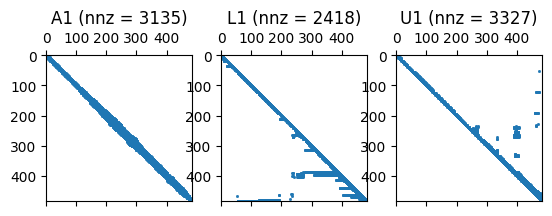

In [87]:
LU1 = sp.linalg.splu(A1, 'COLAMD') # Compute A = LU with column AMD algorithm

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A1, markersize=1)
ax1.set_title('A1 (nnz = ' + str(A1.getnnz()) + ')')
ax2.spy(LU1.L, markersize=1)
ax2.set_title('L1 (nnz = ' + str(LU1.L.getnnz()) + ')')
ax3.spy(LU1.U, markersize=1)
ax3.set_title('U1 (nnz = ' + str(LU1.U.getnnz()) + ')')

plt.show()

The fil-in phenomena is now greatly reduced. Now let's see how much of an effect this makes to the time to solve the problem. We solve again the linear problem $A_1 x = b$ 100 times and measure the time to solve (run a few times to get more accurate measurements):

In [88]:


n = A1.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  LU1 = sp.linalg.splu(A1, 'COLAMD') # Compute A = LU without any reordering
  LU1.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

Mean time spent for one linear solve = 9.225115259999939 milliseconds


We should be able to see a small improvement in the computation time.

Now let's try some more challenging examples:

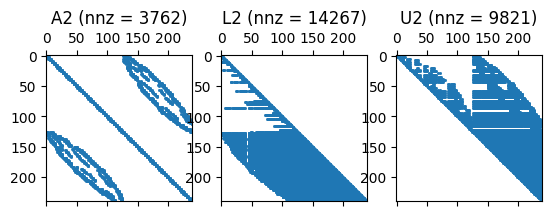

In [89]:


LU2 = sp.linalg.splu(A2, 'NATURAL') # Compute A = LU without any reordering

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A2, markersize=1)
ax1.set_title('A2 (nnz = ' + str(A2.getnnz()) + ')')
ax2.spy(LU2.L, markersize=1)
ax2.set_title('L2 (nnz = ' + str(LU2.L.getnnz()) + ')')
ax3.spy(LU2.U, markersize=1)
ax3.set_title('U2 (nnz = ' + str(LU2.U.getnnz()) + ')')

plt.show()

Here it is clear the unordered LU suffers from severe fill-in.

In [90]:


n = A2.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  LU2 = sp.linalg.splu(A2, 'NATURAL') # Compute A = LU without any reordering
  LU2.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

Mean time spent for one linear solve = 13.998913679999987 milliseconds


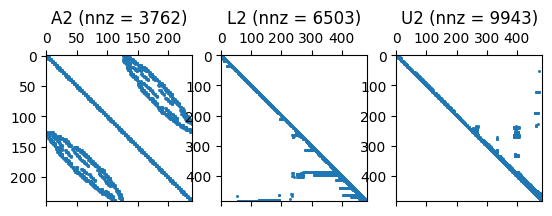

In [91]:
LU2 = sp.linalg.splu(A2, 'COLAMD') # Compute A = LU with column AMD algorithm

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A2, markersize=1)
ax1.set_title('A2 (nnz = ' + str(A2.getnnz()) + ')')
ax2.spy(LU1.L, markersize=1)
ax2.set_title('L2 (nnz = ' + str(LU2.L.getnnz()) + ')')
ax3.spy(LU1.U, markersize=1)
ax3.set_title('U2 (nnz = ' + str(LU2.U.getnnz()) + ')')

plt.show()

We can observe that COLAMD improves the sparsity of $L$ a bit but the problem persists.

In [92]:


n = A2.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  LU1 = sp.linalg.splu(A2, 'COLAMD') # Compute A = LU without any reordering
  LU1.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

Mean time spent for one linear solve = 13.54117893999998 milliseconds


Consequently, the time to solution does not improve.

Let's try one final example:

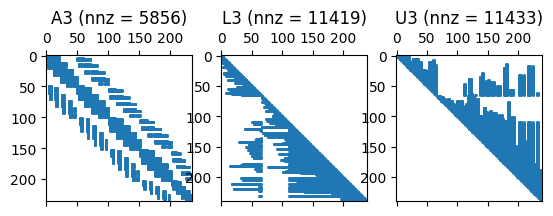

In [93]:


LU3 = sp.linalg.splu(A3, 'NATURAL') # Compute A = LU without any reordering

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A3, markersize=1)
ax1.set_title('A3 (nnz = ' + str(A3.getnnz()) + ')')
ax2.spy(LU2.L, markersize=1)
ax2.set_title('L3 (nnz = ' + str(LU3.L.getnnz()) + ')')
ax3.spy(LU2.U, markersize=1)
ax3.set_title('U3 (nnz = ' + str(LU3.U.getnnz()) + ')')

plt.show()

Again we observe severe fill-in.

In [94]:

n = A3.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  LU1 = sp.linalg.splu(A3, 'NATURAL') # Compute A = LU without any reordering
  LU1.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

Mean time spent for one linear solve = 14.624018509999956 milliseconds


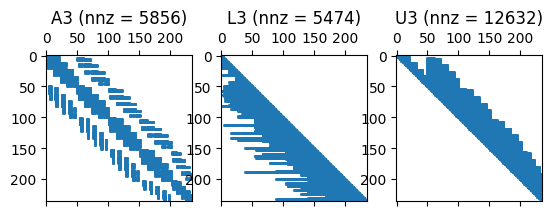

In [95]:
LU3 = sp.linalg.splu(A3, 'COLAMD') # Compute A = LU with column AMD algorithm

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A3, markersize=1)
ax1.set_title('A3 (nnz = ' + str(A3.getnnz()) + ')')
ax2.spy(LU1.L, markersize=1)
ax2.set_title('L3 (nnz = ' + str(LU3.L.getnnz()) + ')')
ax3.spy(LU1.U, markersize=1)
ax3.set_title('U3 (nnz = ' + str(LU3.U.getnnz()) + ')')

plt.show()

In [96]:

n = A3.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  LU1 = sp.linalg.splu(A3, 'COLAMD') # Compute A = LU without any reordering
  LU1.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

Mean time spent for one linear solve = 23.891052580000007 milliseconds


The computational cost actually increases here due to the increased effort required to compute the reordered LU.

In conclusion, we can observe that for almost digonal matrices the AMD reordering can improve the sparsity of the $L$ and $U$ matrices, but for more complex matrices this may offer little improvement. Thus for truly efficient sparse linear algebra, we need to look into indirect solvers that do not explicitly operate with the sparsity pattern of the matrix.